In [23]:
import numpy as np
import pandas as pd
import glob
import os
import xlrd
import openpyxl
import pickle
import matplotlib.pyplot as plt

### Data Request

In [45]:
# Read S&P Global indices
folder_path = 'raw'

# Get all .xls files in the folder
xls_files = glob.glob(os.path.join(folder_path, '*.xls'))

# Read all files
dataframes = []
for file in xls_files:
    df = pd.read_excel(file, skiprows=6, usecols=[0, 1]).iloc[:-1].dropna(how='all')
    df['Effective date '] = pd.to_datetime(df['Effective date '])
    dataframes.append(df)

df_merged = dataframes[0]
for idx in range(1, len(dataframes)):
    df_merged = df_merged.merge(dataframes[idx],  how='outer', on='Effective date ',left_index=False, right_index=False)

In [47]:
# Read two MSCI indices from msci file
msci = pd.read_excel('raw/msci.xlsx', skiprows=5, usecols=[0, 1, 2]).dropna(how='all')
msci['Date'] = pd.to_datetime(msci['Date'])

# Merge msci indices with S&P global indices
df_merged = df_merged.merge(msci,  how='left', left_on='Effective date ', right_on = 'Date', 
                            left_index=False, right_index=False).drop(columns='Date')

In [50]:
df_merged.columns

Index(['Effective date ', 'S&P US Dollar Futures Index TR', 'S&P GSCI TR',
       'S&P Composite 1500 (TR)', 'S&P 500 Value (TR)', 'S&P 600 (TR)',
       'S&P 500 Low Volatility Index TR',
       'S&P U.S. High Yield Corporate Bond Index',
       'S&P U.S. Treasury Bond 10+ Year Index',
       'Cboe S&P 500 Constituent Volatility Index',
       'S&P 500 Momentum Index (US Dollar) Gross Total Return',
       'S&P GSCI (U.S. 10Y TIPS) (USD) TR', 'S&P Bitcoin Index (USD)',
       'S&P 500 Quality (US Dollar) Gross Total Return',
       'S&P Equity Trend (5 Region) Long/Short Index (USD) TR',
       'MSCI World Index', 'MSCI EM (Emerging Markets) Index'],
      dtype='object')

In [ ]:
# # Read vix
# vix = pd.read_csv('raw/vix.csv').dropna(how='all')[['Date','vix']].dropna(how='all')
# vix['Date'] = pd.to_datetime(vix['Date'])
# df_merged = df_merged.merge(vix,  how='left', left_on='Effective date ', right_on = 'Date', 
#                             left_index=False, right_index=False).drop(columns='Date')

In [51]:
# Rename columns
df_merged = df_merged.rename(columns={'Effective date ': 'date',
                          'S&P US Dollar Futures Index TR': 'us_dollar',
                          'S&P GSCI TR': 'commodities',
                          'S&P Composite 1500 (TR)':'us_equity',
                          'S&P 500 Value (TR)': 'value',
                          'S&P 600 (TR)': 'small_cap',
                          'S&P 500 Low Volatility Index TR':'low_vol',
                          'S&P U.S. High Yield Corporate Bond Index': 'credit',
                          'S&P U.S. Treasury Bond 10+ Year Index':'interest_rate',
                          'S&P 500 Momentum Index (US Dollar) Gross Total Return':'momentum',
                          'S&P GSCI (U.S. 10Y TIPS) (USD) TR':'inflation',
                          'S&P Bitcoin Index (USD)':'bitcoin',
                          'S&P 500 Quality (US Dollar) Gross Total Return':'quality',
                          'S&P Equity Trend (5 Region) Long/Short Index (USD) TR':'trend',
                          'MSCI World Index':'equity',
                          'MSCI EM (Emerging Markets) Index':'em_equity',
                          'Cboe S&P 500 Constituent Volatility Index':'long_vol'})
df_merged.set_index('date', inplace=True)

In [52]:
# Map assets to categories
cat_map = {'core_macro': ['commodities', 'credit', 'interest_rate', 'equity'],
           'secondary_macro': ['us_dollar', 'us_equity', 'inflation', 'bitcoin', 'em_equity'],
           'macro_styles': ['trend', 'long_vol'],
           'equity_styles': ['value', 'small_cap', 'low_vol','momentum','quality']}

In [53]:
# Output dataframe and dictionary to a pickle file

with open('data_and_categories.pkl', 'wb') as f:
    pickle.dump({'data': df_merged, 'categories': cat_map}, f)

In [55]:
# Load pickle file
with open('data_and_categories.pkl', 'rb') as f:
    saved = pickle.load(f)
    data = saved['data']
    cat_map = saved['categories']

### Data Cleaning

In [72]:
# Remove exchange holidays (US holidays) from data
data_filtered = data[~data['us_equity'].isna()]  #left with 2531 rows
data_filtered.isna().sum().sort_values(ascending=False)

credit           16
interest_rate    16
em_equity         1
equity            1
value             0
us_equity         0
us_dollar         0
commodities       0
small_cap         0
low_vol           0
long_vol          0
momentum          0
bitcoin           0
inflation         0
trend             0
quality           0
dtype: int64

In [ ]:
# Fill nans with prev value after evaluating the nans
data_filtered = data_filtered.ffill()
data_filtered.isna().sum()

us_dollar        0
commodities      0
us_equity        0
value            0
small_cap        0
low_vol          0
credit           0
interest_rate    0
long_vol         0
momentum         0
inflation        0
bitcoin          0
quality          0
trend            0
equity           0
em_equity        0
dtype: int64

### Data Transformation

In [75]:
log_returns = data_filtered.apply(lambda col: np.log(col / col.shift(1)) ,axis = 0)

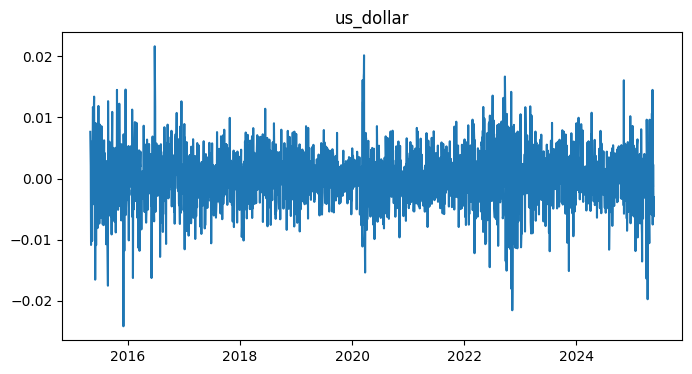

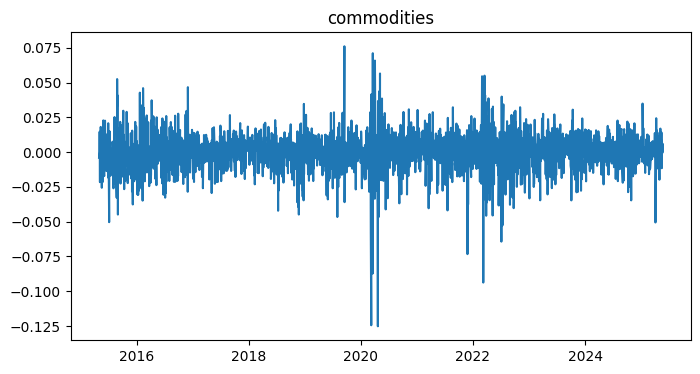

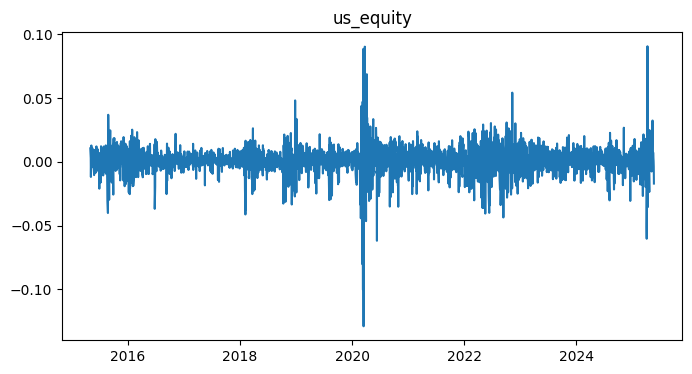

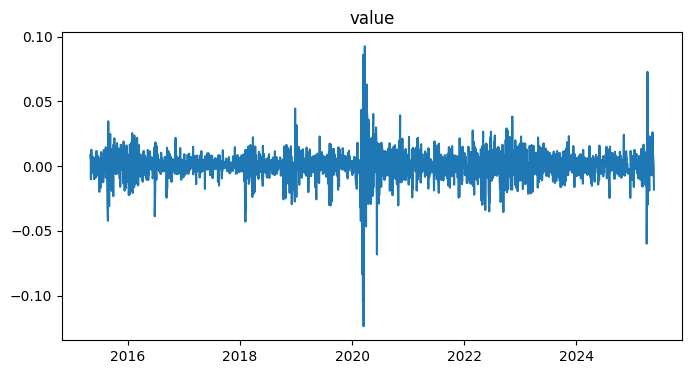

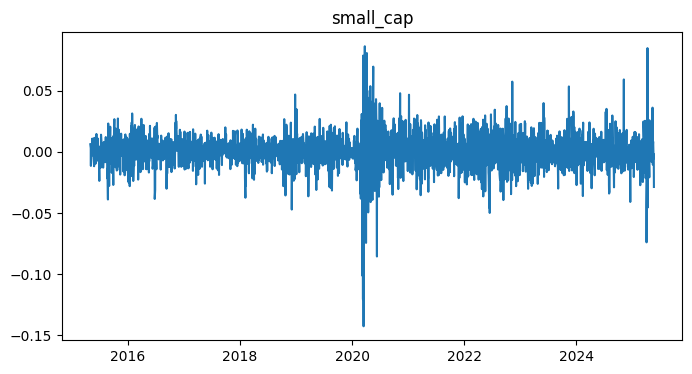

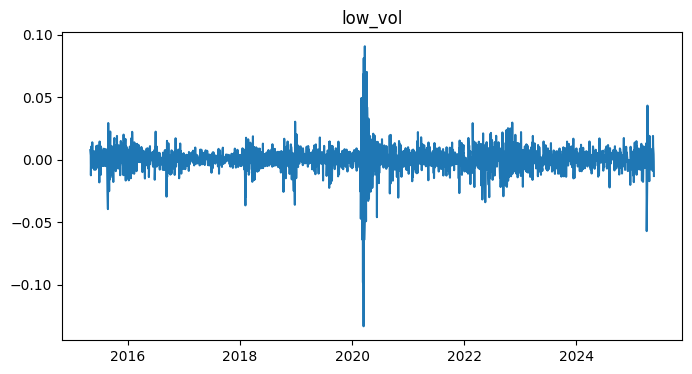

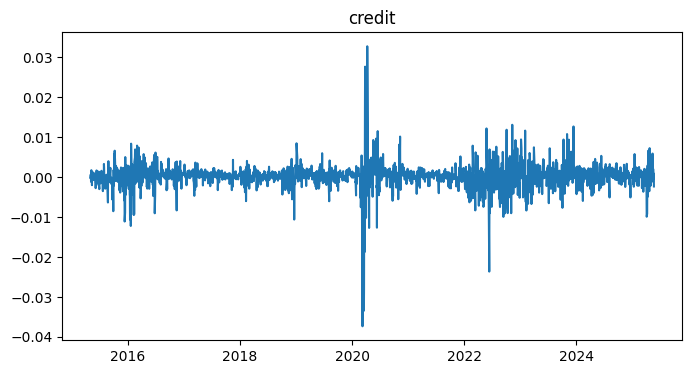

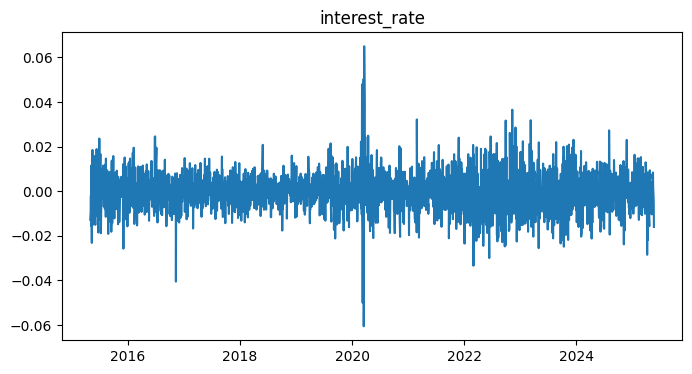

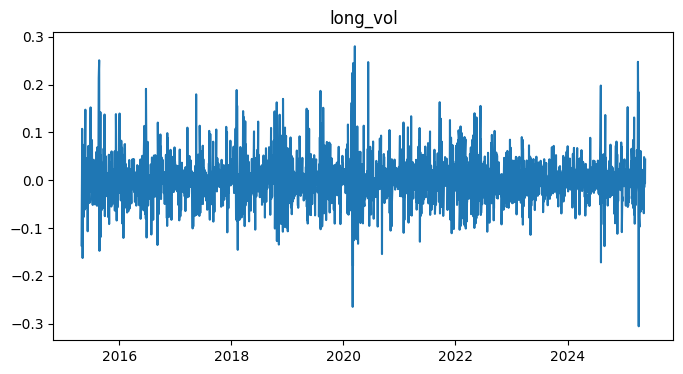

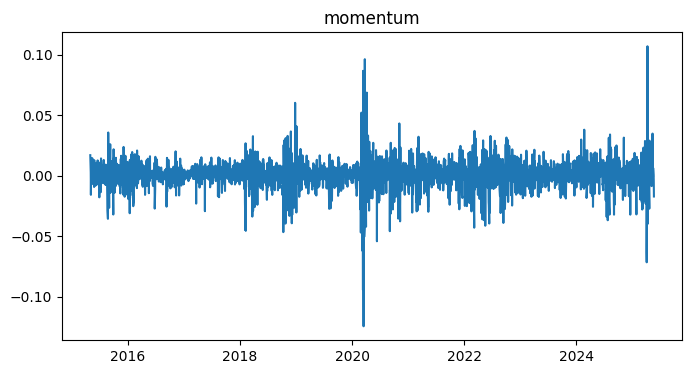

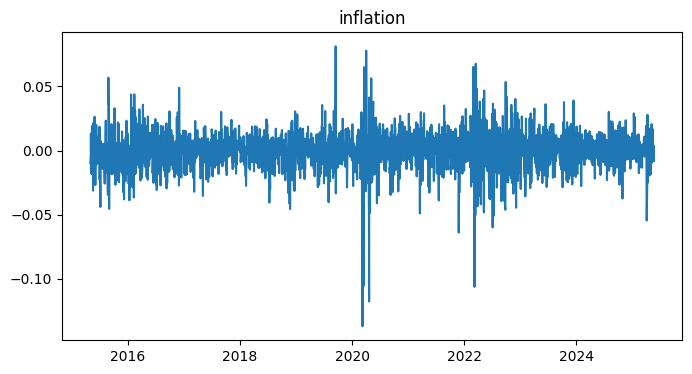

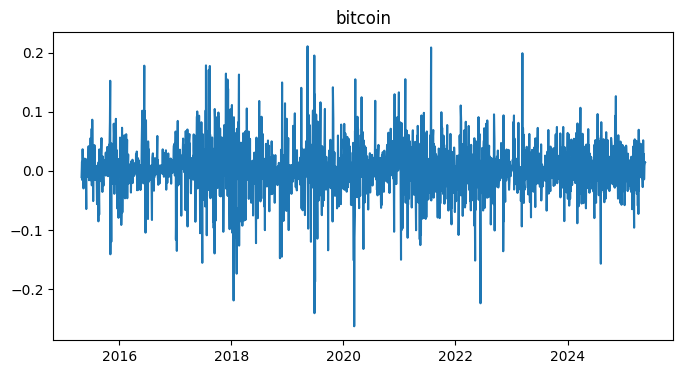

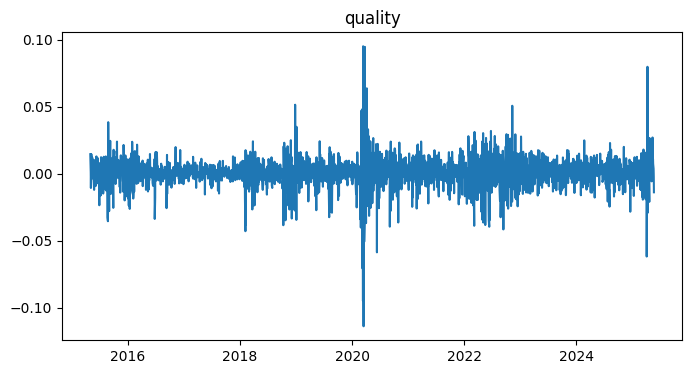

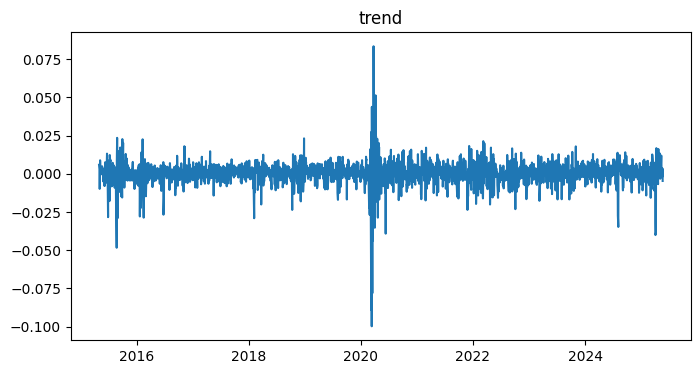

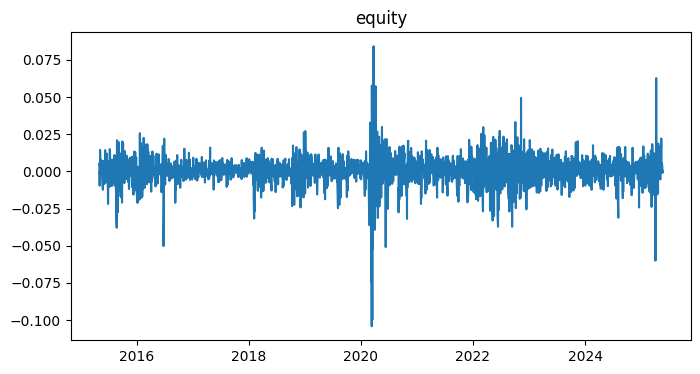

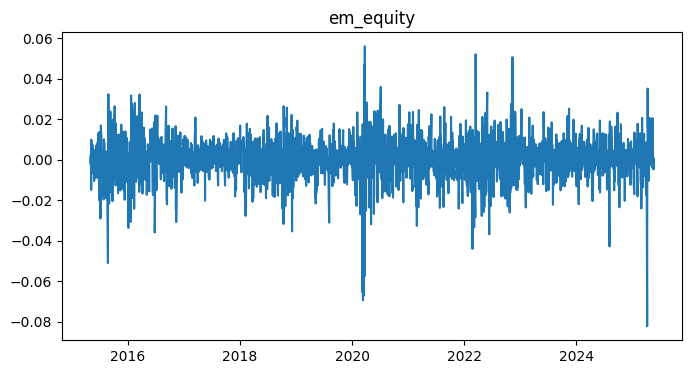

In [ ]:
# Plot return series to make sure no data glitch
for col in log_returns.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(log_returns[col])
    plt.title(f"{col}")
    plt.show()

Export cleaned prices, returns, and asset class mapping to pickle file

In [82]:
return_df = log_returns.iloc[1:]
price_df = data_filtered

df_dict = {'price_df': price_df, 'return_df': return_df, 'category_mapping': cat_map}
import pickle
with open('data_clean.pkl', 'wb') as f:
    pickle.dump(df_dict, f)

In [ ]:
# load dataframes from pickle file
# with open('data_clean.pkl', 'rb') as f:
#     saved = pickle.load(f)
#     price_df = saved['price_df']
#     return_df = saved['return_df']
#     category_map = saved['category_mapping']